In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import math

from torchvision import datasets, transforms
from torch import nn, optim

from tqdm import tqdm
import matplotlib.pyplot as plt

from models.UNet import UNet
from models.VisionTransformer import VisionTransformer

In [4]:
# dynamically select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [5]:
model_config = {
    'in_channels': 3,
    'out_channels': 3,
    'num_layers': 6,
    'time_steps': 100
}

train_config = {
    'image_size': 128,
    'batch_size': 32,
    'learning_rate': 0.00002,
    'weight_decay': 0.000001,
    'max_epochs': 100,
    'save_freq': 10
}

model = UNet(
    in_channels=model_config['in_channels'],
    out_channels=model_config['out_channels'],
    num_layers=model_config['num_layers'],
    time_steps=model_config['time_steps'],
).to(device)

In [9]:
# load trained model
model_path = "/Users/josh/Documents/GitHub/image-diffusion/checkpoints/dim-2026_01_08_18_01_epoch99_end.pth"
chkpt = torch.load(model_path, weights_only=False, map_location=torch.device(device))

# get model configuration
model_config = chkpt['model_config']
train_config = chkpt['train_config']

model = UNet(
    in_channels=model_config['in_channels'],
    out_channels=model_config['out_channels'],
    num_layers=model_config['num_layers'],
    time_steps=model_config['time_steps'],
).to(device)

# model = VisionTransformer(
#     patch_size=model_config['patch_size'],
#     in_channels=model_config['in_channels'],
#     out_channels=model_config['out_channels'],
#     embed_dim=model_config['embed_dim'],
#     num_layers=model_config['num_layers'],
#     num_heads=model_config['num_heads'],
#     time_steps=model_config['time_steps'],
# ).to(device)

model.load_state_dict(chkpt['model_state_dict'])
print(chkpt['loss'])

tensor(0.1047, device='mps:0', requires_grad=True)


In [6]:
transform = transforms.Compose([
    transforms.Resize((train_config['image_size'], train_config['image_size'])),
    transforms.ToTensor(),
    # normalize to [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) if model_config['in_channels'] == 3 else transforms.Normalize((0.5,), (0.5,))
])

# dataloader = torch.utils.data.DataLoader(
#     datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
#     batch_size=1,
#     shuffle=True,
# )

# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(root="./data", train=True, download=False, transform=transform),
#     batch_size=1,
#     shuffle=True,
# )

dataloader = torch.utils.data.DataLoader(
    datasets.StanfordCars(root="./data", split='train', download=False, transform=transform),
    batch_size=1,
    shuffle=True,
)

# dataloader = torch.utils.data.DataLoader(
#     datasets.CelebA(root="./data", split='train', download=False, transform=transform),
#     batch_size=1,
#     shuffle=True,
# )

RuntimeError: Dataset not found. Try to manually download following the instructions in https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616.

In [62]:
example = next(iter(dataloader))[0]

In [ ]:
# dry run
x = torch.randn(train_config['batch_size'], 3, train_config['image_size'], train_config['image_size']).to(device)
t = torch.randint(0, model_config['time_steps'], (train_config['batch_size'],)).to(device)
y = model(x, t)
print(y.shape)

NameError: name 'model' is not defined

In [71]:
# diffusion scheduler
beta = torch.linspace(1e-4, 2e-2, 100, requires_grad=False).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0).requires_grad_(False).to(device)

tensor(0.0196) tensor(0.9843)


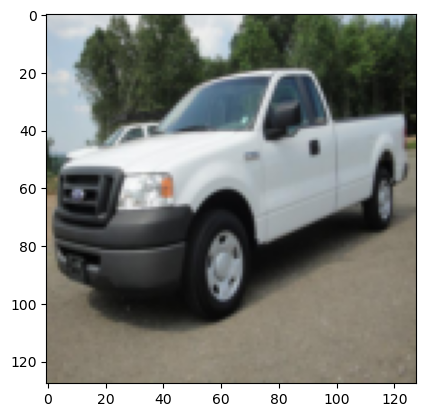

In [77]:
plt.imshow(example.squeeze(0).permute(1, 2, 0).cpu().numpy(), vmin=0, vmax=1)
print(torch.min(example), torch.max(example))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3154515..1.3371178].


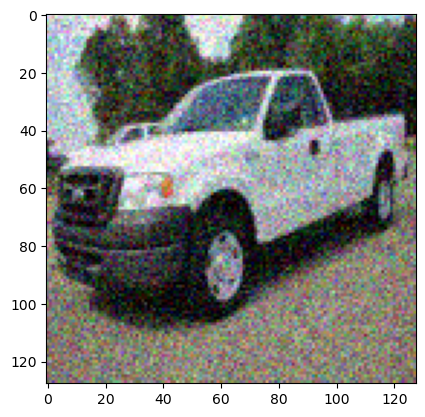

In [76]:
batch = example.to(device)
t = 10
noise = torch.randn(batch.size(), device=batch.device, dtype=batch.dtype).to(device)
diffuse_batch = math.sqrt(alpha_hat[t]) * batch + math.sqrt(1 - alpha_hat[t]) * noise

plt.imshow(diffuse_batch.squeeze(0).permute(1, 2, 0).cpu().numpy(), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0967361..2.4420338].


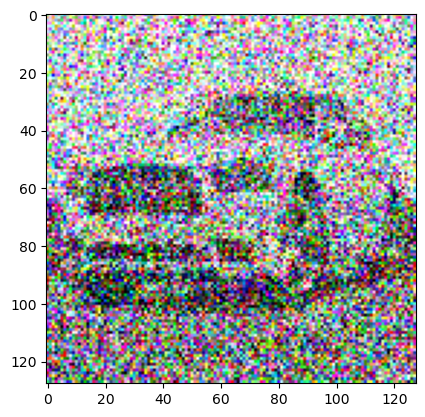

In [27]:
x = diffuse_batch
pred_noise = model(diffuse_batch, torch.tensor([t]).to(device))

if t > 0:
    noise = torch.randn_like(x)
else:
    noise = 0

x = (1 / torch.sqrt(alpha[t])) * (
    x - (beta[t] / torch.sqrt(1 - alpha_hat[t])) * pred_noise
) + torch.sqrt(beta[t]) * noise

plt.imshow((x * 0.5 + 0.5).squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.6159806..8.37758].


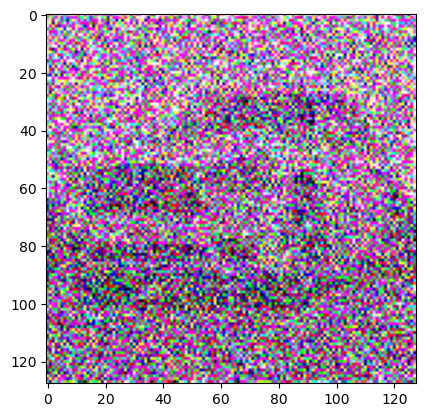

In [28]:
image = diffuse_batch - math.sqrt(1 - alpha_hat[t]) * model(diffuse_batch, torch.tensor([t]).to(device))
image /= math.sqrt(alpha_hat[t])
plt.imshow((image * 0.5 + 0.5).squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23571509..1.3299425].


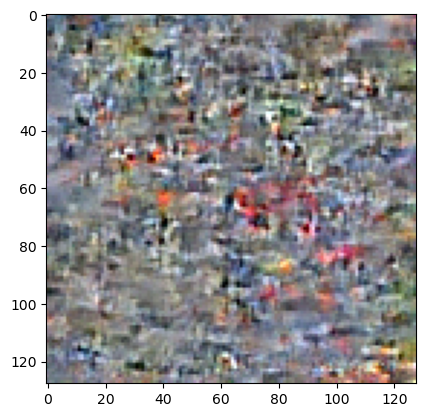

In [18]:
torch.mps.empty_cache()
x = torch.randn(1, model_config['in_channels'], train_config['image_size'], train_config['image_size']).to(device)

for t in reversed(range(0, model_config['time_steps'])):
    # predict noise
    pred_noise = model(x, torch.tensor([t]).to(device))
    x = (1 / torch.sqrt(alpha[t])) * (x - (beta[t] / torch.sqrt(1 - alpha_hat[t])) * pred_noise)

    # add noise up to final generation
    if t > 0:
        x = x + torch.sqrt(beta[t]) * torch.randn_like(x).to(device)

plt.imshow((x * 0.5 + 0.5).squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=1)